# Basic preprocessing and analysis of the human hematopoiesis dataset

Notebook for preprocessing human hematopoiesis dataset

## Library imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
from velovi import preprocess_data

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.preprocessing import prior_GRN_import

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "hematopoiesis"
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Data loading

In [4]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "hsc_dynamo_adata.h5ad")
TF = pd.read_csv(DATA_DIR / DATASET / "raw" / "allTFs_hg38.csv", header=None)
gt_net = pd.read_csv(DATA_DIR / DATASET / "raw" / "skeleton.csv", index_col=0)

## Visualization

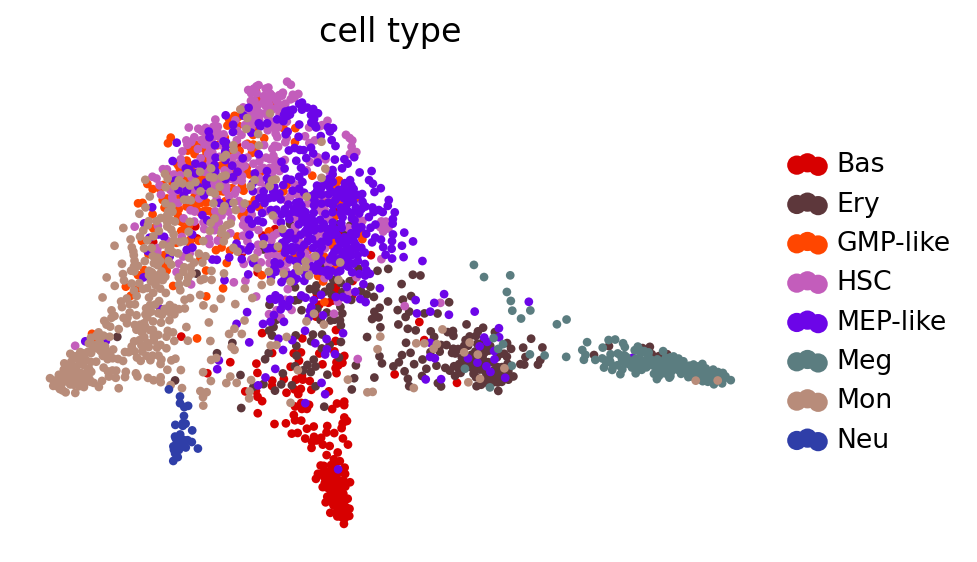

In [5]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.scatter(adata, basis="draw_graph_fa", color="cell_type", frameon=False, ax=ax)

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "intro_figure.svg", format="svg", transparent=True, bbox_inches="tight")

## Preprocessing

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=10, n_top_genes=2000)
sc.pp.neighbors(adata, n_neighbors=50)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 17891 genes that are detected 10 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Load prior gene regulatory graph

In [7]:
reg_bdata = prior_GRN_import(adata, gt_net)

In [8]:
velocity_genes = preprocess_data(reg_bdata).var_names.tolist()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## RegVelo preprocessing

In [9]:
TF_GRN = reg_bdata.var_names[reg_bdata.uns["skeleton"].T.sum(0) != 0].tolist()
TF = list(set(TF.iloc[:, 0].tolist()).intersection(TF_GRN))
reg_bdata.var["TF"] = np.isin(reg_bdata.var_names, TF)

Select genes that are either part of the transcription factor (TF) list or `velocity_genes`

In [10]:
sg = np.union1d(reg_bdata.var_names[reg_bdata.var["TF"]], velocity_genes)

reg_bdata = reg_bdata[:, sg].copy()

In [11]:
reg_bdata = preprocess_data(reg_bdata, filter_on_r2=False)

In [12]:
gene_name = reg_bdata.var_names
full_name = reg_bdata.uns["regulators"]
index = np.isin(full_name, gene_name)
filtered_names = full_name[index]

# Filter the skeleton matrix `W` based on the selected indices
W = reg_bdata.uns["skeleton"][index][:, index]

# Update the filtered values in `uns`
reg_bdata.uns.update({"skeleton": W, "regulators": gene_name.values, "targets": gene_name.values})

In [13]:
scv.tl.velocity(adata)  ## estimate velocity genes

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


## Save dataset

In [14]:
if SAVE_DATA:
    reg_bdata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed_full.h5ad")